PyTorch version: 2.8.0+cu129
CUDA available: True
CUDA version: 12.9
GPU: NVIDIA GeForce RTX 5060 Ti
VRAM: 15.5 GB


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded successfully and moved to: cuda


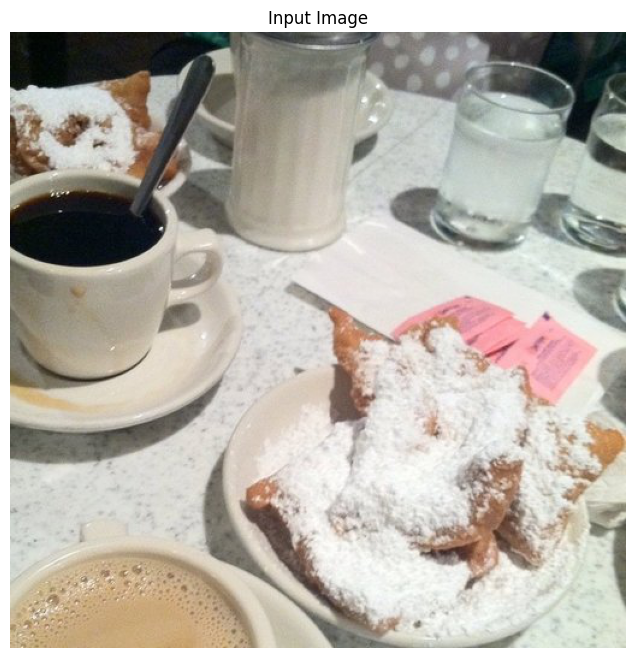

Input tensor shape: torch.Size([1, 3, 800, 800])
Input tensor dtype: torch.float16
Inference completed successfully!
Detected 8 objects


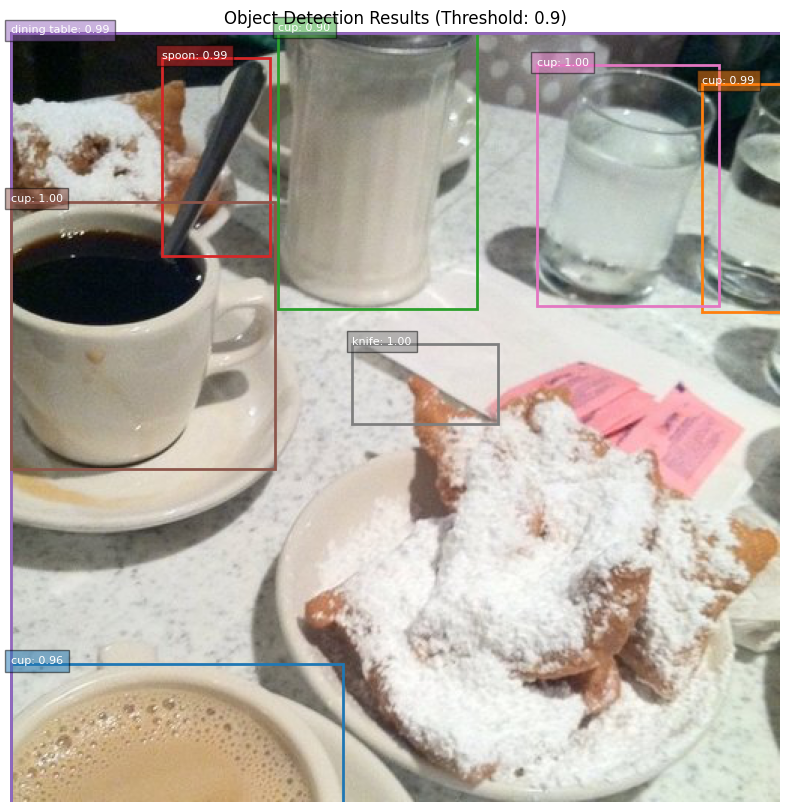

Number of detections above threshold: 8
DETECTION RESULTS
Class                Score      Bounding Box                  
------------------------------------------------------------
cup                  0.9609    [0.1, 419.8, 221.1, 512.5]    
cup                  0.9932    [459.8, 33.8, 512.0, 185.5]   
cup                  0.9023    [178.0, -1.7, 310.0, 183.8]   
spoon                0.9863    [100.4, 16.9, 172.4, 148.2]   
dining table         0.9868    [-0.1, 0.2, 512.0, 512.0]     
cup                  0.9985    [-0.1, 112.2, 175.9, 290.2]   
cup                  0.9961    [349.8, 21.8, 470.8, 182.0]   
knife                0.9956    [227.0, 207.2, 324.0, 260.0]  
Total detections: 8
GPU memory allocated: 0.09 GB
GPU memory reserved: 0.28 GB

Memory Optimization Tips:
1. Use model.half() for half-precision inference
2. Use torch.cuda.empty_cache() to clear unused memory
3. Use smaller batch sizes for larger images
4. Consider using smaller input image sizes
5. Use with torch.no_gr

In [1]:
## Import Necessary Packages"""

import torch
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import DetrForObjectDetection, DetrImageProcessor
from transformers import DetrConfig
import warnings
warnings.filterwarnings('ignore')

# Check CUDA availability and device info
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

"""## Load the Model (with memory optimization)"""

# Use memory-efficient settings for 16GB VRAM
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')  # For better performance on Ampere+ GPUs

# Load processor and model with memory optimization
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Move model to GPU and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Use mixed precision for inference to save memory
from torch.cuda.amp import autocast
model.half()  # Convert to half precision

print("Model loaded successfully and moved to:", device)

"""## Load and Preprocess Image"""

def load_image(image_path):
    """
    Load image from path or URL
    """
    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(image_path).convert("RGB")
    return img

# Load image (you can replace this with your own image path or URL)
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
img = load_image(image_url)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')
plt.show()

"""## Image Preprocessing"""

# Define image transformations
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Preprocess the image
img_tensor = transform(img).unsqueeze(0).to(device).half()  # Use half precision

print(f"Input tensor shape: {img_tensor.shape}")
print(f"Input tensor dtype: {img_tensor.dtype}")

"""## Perform Inference with Memory Management"""

# Free up memory before inference
torch.cuda.empty_cache()

# Perform inference with autocast for mixed precision
with torch.no_grad(), autocast():
    outputs = model(img_tensor)

# Process the outputs
target_sizes = torch.tensor([img.size[::-1]]).to(device)
results = processor.post_process_object_detection(
    outputs, 
    target_sizes=target_sizes, 
    threshold=0.9
)[0]

print("Inference completed successfully!")
print(f"Detected {len(results['scores'])} objects")

"""## Visualization Functions"""

def visualize_predictions(image, results, threshold=0.9):
    """
    Visualize the predictions on the image
    """
    plt.figure(figsize=(16, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Filter predictions by threshold
    keep = results['scores'] >= threshold
    scores = results['scores'][keep].cpu().numpy()
    labels = results['labels'][keep].cpu().numpy()
    boxes = results['boxes'][keep].cpu().numpy()
    
    colors = plt.cm.tab10(range(len(scores)))
    
    for score, label, box, color in zip(scores, labels, boxes, colors):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        # Create rectangle patch
        rect = plt.Rectangle(
            (xmin, ymin), width, height, 
            fill=False, color=color, linewidth=2
        )
        ax.add_patch(rect)
        
        # Add label text
        label_text = f"{model.config.id2label[label]}: {score:.2f}"
        ax.text(
            xmin, ymin, label_text,
            bbox=dict(facecolor=color, alpha=0.5),
            fontsize=8, color='white'
        )
    
    plt.axis('off')
    plt.title(f'Object Detection Results (Threshold: {threshold})')
    plt.show()
    
    return len(scores)

# Visualize the results
num_detections = visualize_predictions(img, results, threshold=0.9)
print(f"Number of detections above threshold: {num_detections}")

"""## Detailed Results Analysis"""

def print_detailed_results(results, threshold=0.9):
    """
    Print detailed information about the detections
    """
    keep = results['scores'] >= threshold
    scores = results['scores'][keep].cpu().numpy()
    labels = results['labels'][keep].cpu().numpy()
    boxes = results['boxes'][keep].cpu().numpy()
    
    print("=" * 60)
    print("DETECTION RESULTS")
    print("=" * 60)
    print(f"{'Class':<20} {'Score':<10} {'Bounding Box':<30}")
    print("-" * 60)
    
    for score, label, box in zip(scores, labels, boxes):
        class_name = model.config.id2label[label]
        bbox_str = f"[{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]"
        print(f"{class_name:<20} {score:.4f}    {bbox_str:<30}")
    
    print("=" * 60)
    print(f"Total detections: {len(scores)}")

# Print detailed results
print_detailed_results(results, threshold=0.9)

"""## Memory Optimization Tips"""

def check_memory_usage():
    """
    Check and display GPU memory usage
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory reserved: {reserved:.2f} GB")
    else:
        print("CUDA not available")

check_memory_usage()

# Tips for memory optimization
print("\nMemory Optimization Tips:")
print("1. Use model.half() for half-precision inference")
print("2. Use torch.cuda.empty_cache() to clear unused memory")
print("3. Use smaller batch sizes for larger images")
print("4. Consider using smaller input image sizes")
print("5. Use with torch.no_grad(): during inference")

"""## Batch Processing Example (Optional)"""

def process_batch(image_paths, threshold=0.8):
    """
    Process a batch of images for object detection
    """
    results = []
    
    for image_path in image_paths:
        try:
            # Load and preprocess image
            img = load_image(image_path)
            img_tensor = transform(img).unsqueeze(0).to(device).half()
            
            # Perform inference
            with torch.no_grad(), autocast():
                outputs = model(img_tensor)
            
            # Process results
            target_sizes = torch.tensor([img.size[::-1]]).to(device)
            result = processor.post_process_object_detection(
                outputs, 
                target_sizes=target_sizes, 
                threshold=threshold
            )[0]
            
            results.append((img, result))
            
            # Free memory
            del img_tensor, outputs
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            results.append(None)
    
    return results

# Example usage (uncomment to use)
# batch_images = [image_url, "path/to/another/image.jpg"]
# batch_results = process_batch(batch_images, threshold=0.8)

"""## Save and Load Results"""

import json
import numpy as np

def save_results(results, image_path, output_path):
    """
    Save detection results to a JSON file
    """
    # Convert tensors to numpy arrays and then to lists
    detections = []
    for score, label, box in zip(results['scores'].cpu().numpy(), 
                                results['labels'].cpu().numpy(), 
                                results['boxes'].cpu().numpy()):
        detections.append({
            'label': int(label),
            'label_name': model.config.id2label[int(label)],
            'score': float(score),
            'box': box.tolist()
        })
    
    # Create result dictionary
    result_data = {
        'image_path': image_path,
        'detections': detections
    }
    
    # Save to JSON
    with open(output_path, 'w') as f:
        json.dump(result_data, f, indent=2)
    
    print(f"Results saved to {output_path}")

def load_results(input_path):
    """
    Load detection results from a JSON file
    """
    with open(input_path, 'r') as f:
        result_data = json.load(f)
    
    return result_data

# Example usage (uncomment to use)
# save_results(results, image_url, "detection_results.json")
# loaded_results = load_results("detection_results.json")

"""## Performance Benchmarking"""

import time

def benchmark_inference(image, num_runs=10):
    """
    Benchmark the inference performance
    """
    # Preprocess image
    img_tensor = transform(image).unsqueeze(0).to(device).half()
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    
    # Warmup
    with torch.no_grad(), autocast():
        _ = model(img_tensor)
    
    # Benchmark
    times = []
    for _ in range(num_runs):
        torch.cuda.synchronize()
        start_time = time.time()
        
        with torch.no_grad(), autocast():
            outputs = model(img_tensor)
        
        torch.cuda.synchronize()
        end_time = time.time()
        times.append(end_time - start_time)
    
    # Calculate statistics
    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    std_time = np.std(times) * 1000
    fps = 1 / np.mean(times)
    
    print(f"Average inference time: {avg_time:.2f} ms (± {std_time:.2f} ms)")
    print(f"FPS: {fps:.2f}")
    
    return times

# Run benchmark
print("Running performance benchmark...")
inference_times = benchmark_inference(img, num_runs=10)

"""## Conclusion

This notebook demonstrates how to use the DETR model for object detection with updated dependencies optimized for CUDA 12.x and 16GB VRAM. Key features:

1. **Updated Dependencies**: Compatible with the latest PyTorch and CUDA versions
2. **Memory Optimization**: Uses half-precision and memory management techniques
3. **Visualization**: Clear visualization of detection results
4. **Performance**: Includes benchmarking and optimization tips
5. **Utility Functions**: Save/load results and batch processing capabilities

The model should work efficiently within 16GB VRAM constraints for most images.
"""

# Final memory check
check_memory_usage()
print("\nNotebook execution completed successfully!")